# Benchmarking Numberlink Solvers

In [1]:
import sys
import os

# Add the `backend` folder to the path
sys.path.append(os.path.abspath("../backend"))

In [2]:
import time

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from solvers import solvers

In [3]:
def benchmark_solver(solver, puzzles):
    times = []
    for index in range(len(puzzles)):
        puzzle = puzzles[index]
        start_time = time.time()
        if solver(puzzle) is None:
            print(f"Failed to solve puzzle {index}")
            continue
        end_time = time.time()
        print(f"Solved puzzle {index} in {end_time - start_time} seconds")
        times.append(end_time - start_time)
    return times

In [4]:
import signal
import time
from contextlib import contextmanager

@contextmanager
def time_limit(seconds):
    def timeout_handler(signum, frame):
        raise TimeoutError("Function execution exceeded the time limit!")

    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

In [5]:
import json

with open("puzzles.json", "r") as f:
    puzzles = json.load(f)
    puzzles.sort(key=lambda x: x["dimension"])
puzzle_sizes = [puzzle["dimension"] for puzzle in puzzles]
puzzle_sizes

[4, 5, 6, 7, 8, 9, 10, 11]

In [6]:
from concurrent.futures import ThreadPoolExecutor, TimeoutError

MAX_RUNTIME = 1  # seconds

In [7]:
from tqdm import tqdm

results = {"Solver": [], "Puzzle Set": [], "Puzzle Number": [], "Time (s)": []}
NUM_PUZZLES_TO_SOLVE = 200


In [8]:
def verify_solution(puzzle, maybe_solution):
    # verify no zeros in the solution
    for i in range(len(maybe_solution)):
        for j in range(len(maybe_solution[i])):
            if maybe_solution[i][j] == 0:
                return False

    # all non-zero of the puzzle are still the same
    for i in range(len(puzzle)):
        for j in range(len(puzzle[i])):
            if puzzle[i][j] != 0 and puzzle[i][j] != maybe_solution[i][j]:
                return False

    # all the pathways for one number are connected, i.e. the number of connected components is the same as the number of numbers
    visited = [[False for _ in range(len(puzzle[i]))] for i in range(len(puzzle))]
    def dfs(i, j, val):
        if i < 0 or j < 0 or i >= len(puzzle) or j >= len(puzzle[i]) or visited[i][j] or maybe_solution[i][j] != val:
            return
        visited[i][j] = True
        for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
            dfs(i + dx, j + dy, val)

    num_connected_components = 0
    for i in range(len(puzzle)):
        for j in range(len(puzzle[i])):
            if not visited[i][j]:
                num_connected_components += 1
                dfs(i, j, maybe_solution[i][j])
    
    num_numbers = len({puzzle[i][j] for i in range(len(puzzle)) for j in range(len(puzzle[i])) if puzzle[i][j] != 0})
    return num_connected_components == num_numbers

In [9]:
MIN_DIMENSION = 5
MAX_DIMENSION = 5

In [10]:
def benchmark(solver_name):
    solver = solvers[solver_name]
    for puzzle in puzzles:
        dimension = puzzle["dimension"]
        if dimension < MIN_DIMENSION or dimension > MAX_DIMENSION:
            continue
        items = puzzle["items"]
        if len(items) < NUM_PUZZLES_TO_SOLVE:
            print(
                f"Warning: Not enough puzzles for {solver_name} {dimension}x{dimension}"
            )
        items = items[:NUM_PUZZLES_TO_SOLVE]
        for i, item in tqdm(
            enumerate(items, 1),
            desc=f"{solver_name} {dimension}x{dimension}",
            total=len(items),
        ):
            start_time = time.perf_counter_ns()
            puzzle = item["puzzle"]
            with ThreadPoolExecutor(max_workers=1) as executor:
                future = executor.submit(solver, puzzle)
                try:
                    result = future.result(timeout=MAX_RUNTIME)
                    if result is None:
                        print(f"Failed to solve puzzle {i}")
                        continue
                except TimeoutError:
                    # print(f"Solver {solver_name} took too long on puzzle {i}")
                    time.sleep(2) # helps with the timeout?
                    break

            # verify the result
            solution = item["solution"]
            if not verify_solution(puzzle, result):
                print(f"Solver {solver_name} failed on puzzle {i}")
                print("Puzzle: ")
                for row in puzzle:
                    print(row)
                print('-' * 10)
                print("Expected: ")
                for row in solution:
                    print(row)
                print('-' * 10)
                print("Got: ")
                for row in result:
                    print(row)
                break

            end_time = time.perf_counter_ns()
            results["Solver"].append(solver_name)
            results["Puzzle Set"].append(f"{dimension}x{dimension}")
            results["Puzzle Number"].append(i)
            results["Time (s)"].append(end_time - start_time)

print(solvers.keys())

benchmark("PycoEdgeSolver")

dict_keys(['ConstraintPathSolver', 'PycoPathSolver', 'PycoEdgeSolver'])


PycoEdgeSolver 5x5:   6%|▌         | 11/200 [00:06<01:45,  1.79it/s]

Solver PycoEdgeSolver failed on puzzle 12
Puzzle: 
[0, 0, 0, 0, 1]
[1, 0, 0, 0, 0]
[3, 0, 3, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 2]
----------
Expected: 
[1, 1, 1, 1, 1]
[1, 2, 2, 2, 2]
[3, 2, 3, 3, 2]
[3, 2, 2, 3, 2]
[3, 3, 3, 3, 2]
----------
Got: 
[1, 1, 1, 1, 1]
[1, 3, 3, 3, 3]
[3, 3, 3, 3, 3]
[1, 1, 2, 3, 3]
[1, 1, 2, 2, 2]


In [11]:
benchmark("ConstraintPathSolver")

ConstraintPathSolver 5x5: 100%|██████████| 200/200 [00:17<00:00, 11.21it/s]


In [12]:
benchmark("PycoPathSolver")

PycoPathSolver 5x5: 100%|██████████| 200/200 [00:29<00:00,  6.86it/s]


In [13]:
benchmark("PycoEdgeSolver")

PycoEdgeSolver 5x5:   6%|▌         | 11/200 [00:06<01:43,  1.82it/s]

Solver PycoEdgeSolver failed on puzzle 12
Puzzle: 
[0, 0, 0, 0, 1]
[1, 0, 0, 0, 0]
[3, 0, 3, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 2]
----------
Expected: 
[1, 1, 1, 1, 1]
[1, 2, 2, 2, 2]
[3, 2, 3, 3, 2]
[3, 2, 2, 3, 2]
[3, 3, 3, 3, 2]
----------
Got: 
[1, 1, 1, 1, 1]
[1, 3, 3, 3, 3]
[3, 3, 3, 3, 3]
[1, 1, 2, 3, 3]
[1, 1, 2, 2, 2]


In [14]:
df_results = pd.DataFrame(results)

In [15]:
df_results.to_csv("results.csv", index=False)

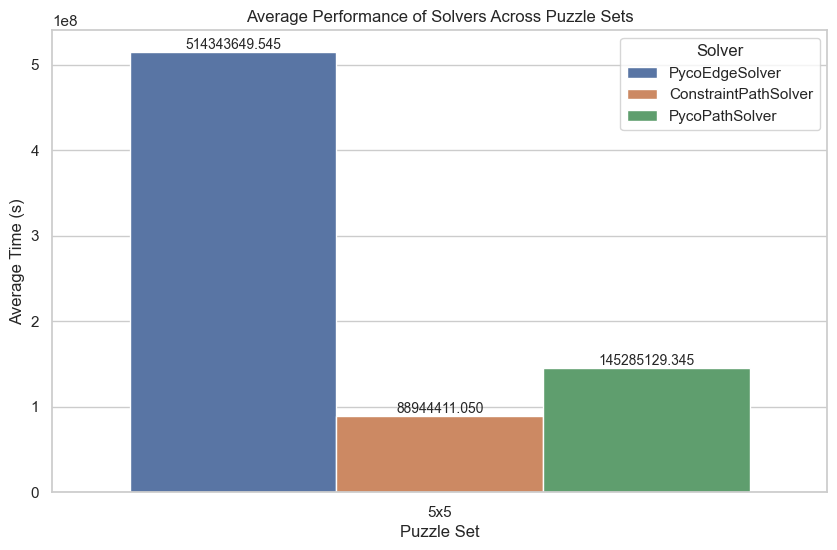

In [16]:
# Set style for the plot
sns.set(style="whitegrid")

# Create the bar plot without error bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x="Puzzle Set", y="Time (s)", hue="Solver", data=df_results, errorbar=None
)
plt.title("Average Performance of Solvers Across Puzzle Sets")
plt.xlabel("Puzzle Set")
plt.ylabel("Average Time (s)")
plt.legend(title="Solver")

# Add the values on top of the bars
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

plt.show()